In [14]:
import sys
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [15]:
sys.path.append("../src/")

from metrics import mae, rmse, smape, print_metrics
from network import Network
from utils import (
    plot_error_prediction,
    plot_absolute_error,
    plot_absolute_error_histogram,
    plot_average_error,
    plot_distance_and_error,
    plot_neurons,
)


## Dataset Generation Documentation

---

#### `generate_dataset(ret_shape, num_samples, scope, sensitivity, train_ratio, crosstalk_peak_events, ambient_light_level, noise_std_dev)`

Generates a synthetic dataset for training and testing purposes based on specified parameters.

**Parameters:**
- `ret_shape`: Response shape array representing a signal.
- `num_samples`: Number of data samples to generate.
- `scope`: Maximum scope in centimeters for the signal.
- `sensitivity`: Sensor sensitivity in centimeters.
- `train_ratio`: Proportion of data used for training.
- `crosstalk_peak_events`: Peak events magnitude for crosstalk signals.
- `ambient_light_level`: Background light level affecting the signal.
- `noise_std_dev`: Standard deviation for noise addition.

**Returns:**
- `df`: Pandas DataFrame containing the full dataset.
- `x_train`, `y_train`: Arrays for training features and labels.
- `x_test`, `y_test`: Arrays for testing features and labels.
- `num_values`: Number of feature values per sample.

---

#### `generate_sample(crosstalk_peak_events, ambient_light_level, noise_std_dev, num_values, sampled_ret_shape, crosstalk_position_init, cm_sen)`

Generates a single data sample including signal and corresponding label.

**Parameters:**
- `crosstalk_peak_events`: Magnitude of crosstalk events.
- `ambient_light_level`: Baseline ambient light intensity.
- `noise_std_dev`: Noise standard deviation.
- `num_values`: Length of the signal sample.
- `sampled_ret_shape`: Pre-sampled shape of the return signal.
- `crosstalk_position_init`: Initial position for crosstalk within the signal.
- `cm_sen`: Sensitivity scaling factor.

**Returns:**
- `final_signal`: Generated signal with noise.
- `output`: Normalized position of the detected object within the signal.
- `object_position`: Actual position of the object in the signal.

---

#### `create_impulse_train(crosstalk_peak_events, num_values, object_position, crosstalk_position_init, cm_sen)`

Creates an impulse train representing crosstalk and object signals.

**Parameters:**
- `crosstalk_peak_events`: Peak magnitude for crosstalk events.
- `num_values`: Length of the impulse array.
- `object_position`: Position of the detected object.
- `crosstalk_position_init`: Initial position of the crosstalk impulse.
- `cm_sen`: Adjustment factor for impulse position variability.

**Returns:**
- `impulse_train`: Array representing impulse positions and magnitudes.

---

#### `add_noise(signal, ambient_light_level, noise_std_dev)`

Adds realistic noise and ambient light effects to a signal.

**Parameters:**
- `signal`: Original signal array.
- `ambient_light_level`: Level of ambient light added to the signal.
- `noise_std_dev`: Noise standard deviation.

**Returns:**
- `signal_noisy_clipped`: Signal array with noise, clipped to remove negative values.



In [ ]:
def generate_dataset(ret_shape, num_samples, scope, sensitivity, train_ratio, 
                      crosstalk_peak_events, ambient_light_level, noise_std_dev):
    # scope y sensitivity en cm
    step_t = 0.0025  # Pasos del ret_shape en ps
    cm_t = 0.125  # Tiempo en ps para hacer 1 cm
    cm_bin = int(cm_t / step_t)
    
    scope_bin = scope * cm_bin
    sensitivity_bin = int(sensitivity * cm_bin)  # Parámetro a definir
    
    num_values = int(scope_bin / sensitivity_bin)
    crosstalk_position_init = int((np.random.uniform(4,100)* cm_bin) / sensitivity_bin)
    cm_sen = cm_bin / sensitivity_bin

    if len(ret_shape) > scope_bin:
        sampled_ret_shape = ret_shape[::sensitivity_bin][:num_values]
    else:
        sampled_ret_shape = np.pad(ret_shape, (0, max(0, num_values - len(ret_shape))), 'constant')

    data = np.zeros((num_samples, num_values + 1))

    for i in tqdm(range(num_samples)):
        sample, output, object_position = generate_sample(
            crosstalk_peak_events, ambient_light_level, noise_std_dev, num_values, 
            sampled_ret_shape, crosstalk_position_init, cm_sen
        )
        data[i, :-1] = sample
        data[i, -1] = output
        
    columns = [f'distance_{i+1}' for i in range(num_values)] + ['output']
    df = pd.DataFrame(data, columns=columns).sample(frac=1).reset_index(drop=True)

    train_size = int(num_samples * train_ratio)
    x_train = df.iloc[:train_size, :-1].to_numpy()
    y_train = df.iloc[:train_size, -1].to_numpy()
    x_test = df.iloc[train_size:, :-1].to_numpy()
    y_test = df.iloc[train_size:, -1].to_numpy()

    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

    return df, x_train, y_train, x_test, y_test, num_values


def generate_sample(crosstalk_peak_events, ambient_light_level, noise_std_dev, num_values, 
                     sampled_ret_shape, crosstalk_position_init, cm_sen):
                     
    object_position = np.random.randint(int(crosstalk_position_init ), num_values - 3)

    impulse_train = create_impulse_train(crosstalk_peak_events, num_values, object_position, crosstalk_position_init, cm_sen)
    signal = np.convolve(impulse_train, sampled_ret_shape, mode='full')
    signal_length = len(signal)
    if signal_length < num_values:
        signal = np.pad(signal, (0, num_values - signal_length), 'constant')
    elif signal_length > num_values:
        signal = signal[:num_values]

    max_value = np.max(signal)
    if max_value != 0:
        signal /= max_value

    final_signal = add_noise(signal, ambient_light_level, noise_std_dev)

    output = object_position / (num_values - 1)

    return final_signal, output, object_position


def create_impulse_train(crosstalk_peak_events, num_values, object_position, crosstalk_position_init, cm_sen):
    impulse_train = np.zeros(num_values)
    crosstalk_position = int(crosstalk_position_init) + np.random.randint(-max(1,cm_sen), max(1,cm_sen))
    object_peak_events = np.random.uniform(0.7, 0.9)
    impulse_train[crosstalk_position] = object_peak_events * crosstalk_peak_events

    if object_position is not None:
        impulse_train[object_position] = object_peak_events
    
    return impulse_train


def add_noise(signal, ambient_light_level, noise_std_dev):
    signal_with_ambient = signal + ambient_light_level
    noise = np.random.randn(*signal_with_ambient.shape) * np.sqrt(np.maximum(signal_with_ambient, 0)) * noise_std_dev
    signal_noisy = signal_with_ambient + noise
    signal_noisy_clipped = np.clip(signal_noisy, 0, None)
    
    return signal_noisy_clipped







In [129]:
def generate_dataset(ret_shape, num_samples, scope, sensitivity, train_ratio, 
                      crosstalk_peak_events, ambient_light_level, noise_std_dev):
    # scope y sensitivity en cm
    step_t = 0.0025      # pasos del ret_shape en ps
    cm_t = 0.125         # tiempo en ps que equivale a 1 cm
    cm_bin = int(cm_t / step_t)
    
    scope_bin = scope * cm_bin
    sensitivity_bin = int(sensitivity * cm_bin)
    
    num_values = int(scope_bin / sensitivity_bin)
    cm_sen = cm_bin / sensitivity_bin  # relación
    
    if len(ret_shape) > scope_bin:
        sampled_ret_shape = ret_shape[::sensitivity_bin][:num_values]
    else:
        sampled_ret_shape = np.pad(ret_shape, (0, max(0, num_values - len(ret_shape))), 'constant')
    
    data = np.zeros((num_samples, num_values + 1))
    
    # Se calcula la posición base del crosstalk como antes (sin modificar)
    crosstalk_position_init = int((np.random.uniform(4, 100) * cm_bin) / sensitivity_bin)
    
    for i in tqdm(range(num_samples)):
        sample, output, object_position = generate_sample(
            crosstalk_peak_events, ambient_light_level, noise_std_dev, num_values, 
            sampled_ret_shape, crosstalk_position_init, cm_bin, sensitivity_bin, cm_sen
        )
        data[i, :-1] = sample
        data[i, -1] = output
    
    columns = [f'distance_{i+1}' for i in range(num_values)] + ['output']
    df = pd.DataFrame(data, columns=columns).sample(frac=1).reset_index(drop=True)
    
    train_size = int(num_samples * train_ratio)
    x_train = df.iloc[:train_size, :-1].to_numpy()
    y_train = df.iloc[:train_size, -1].to_numpy()
    x_test = df.iloc[train_size:, :-1].to_numpy()
    y_test = df.iloc[train_size:, -1].to_numpy()
    
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)
    
    return df, x_train, y_train, x_test, y_test, num_values


def generate_sample(crosstalk_peak_events, ambient_light_level, noise_std_dev, num_values, 
                     sampled_ret_shape, crosstalk_position_init, cm_bin, sensitivity_bin, cm_sen):
    # Posición mínima en bins equivalente a 4 cm
    min_object_position = int((4 * cm_bin) / sensitivity_bin)
    if min_object_position >= num_values:
        min_object_position = 0
    # Se elige el objeto en cualquier posición desde 4 cm hasta el final
    object_position = np.random.randint(min_object_position, num_values)
    
    impulse_train = create_impulse_train(crosstalk_peak_events, num_values, object_position, crosstalk_position_init, cm_sen)
    signal = np.convolve(impulse_train, sampled_ret_shape, mode='full')
    signal_length = len(signal)
    if signal_length < num_values:
        signal = np.pad(signal, (0, num_values - signal_length), 'constant')
    elif signal_length > num_values:
        signal = signal[:num_values]
    
    max_value = np.max(signal)
    if max_value != 0:
        signal /= max_value
    
    final_signal = add_noise(signal, ambient_light_level, noise_std_dev)
    
    # Normaliza para que output esté entre 0 y 1
    output = object_position / (num_values - 1)
    
    return final_signal, output, object_position


def create_impulse_train(crosstalk_peak_events, num_values, object_position, crosstalk_position_init, cm_sen):
    impulse_train = np.zeros(num_values)
    object_peak_events = np.random.uniform(0.7, 0.9)
    
    # Se genera la posición del crosstalk como en el código original
    crosstalk_position = int(crosstalk_position_init) + np.random.randint(-max(1, int(cm_sen)), max(1, int(cm_sen)))
    crosstalk_position = np.clip(crosstalk_position, 0, num_values - 1)
    
    # Se suman los impulsos en la posición correspondiente (si coinciden se acumulan)
    impulse_train[object_position] += object_peak_events
    impulse_train[crosstalk_position] += object_peak_events * crosstalk_peak_events
    
    return impulse_train


def add_noise(signal, ambient_light_level, noise_std_dev):
    signal_with_ambient = signal + ambient_light_level
    noise = np.random.randn(*signal_with_ambient.shape) * np.sqrt(np.maximum(signal_with_ambient, 0)) * noise_std_dev
    signal_noisy = signal_with_ambient + noise
    signal_noisy_clipped = np.clip(signal_noisy, 0, None)
    
    return signal_noisy_clipped


In [131]:

ret_shape = np.loadtxt('ret_shape.txt')
num_samples=5000
scope=200
sensitivity=0.5
train_ratio=0.7
crosstalk_peak_events=0.8
ambient_light_level=0.2
noise_std_dev=0.3


df, x_train, y_train, x_test, y_test, num_value = generate_dataset(ret_shape=ret_shape,
                                                        num_samples=num_samples,
                                                        scope=scope,
                                                        sensitivity=sensitivity,
                                                        train_ratio=train_ratio,
                                                        crosstalk_peak_events=crosstalk_peak_events,
                                                        ambient_light_level=ambient_light_level,
                                                        noise_std_dev=noise_std_dev)

print(df.head())
print(num_value)


100%|██████████| 5000/5000 [00:00<00:00, 6242.38it/s]

x_train shape: (3500, 400)
y_train shape: (3500,)
x_test shape: (1500, 400)
y_test shape: (1500,)
   distance_1  distance_2  distance_3  distance_4  distance_5  distance_6  \
0    0.332464    0.372007    0.315586    0.145705    0.150680    0.302682   
1    0.035314    0.384519    0.102714    0.488239    0.132280    0.000252   
2    0.050141    0.235063    0.000000    0.043366    0.000000    0.240171   
3    0.273063    0.082105    0.095545    0.115973    0.000000    0.433690   
4    0.104070    0.130629    0.288768    0.183370    0.202957    0.208270   

   distance_7  distance_8  distance_9  distance_10  ...  distance_392  \
0    0.226937    0.125174    0.260244     0.492904  ...      0.090948   
1    0.148765    0.105398    0.411982     0.137159  ...      0.971880   
2    0.343939    0.302922    0.418812     0.062244  ...      0.248743   
3    0.145677    0.120534    0.092728     0.219259  ...      1.190325   
4    0.126910    0.175291    0.512632     0.348745  ...      0.137808   



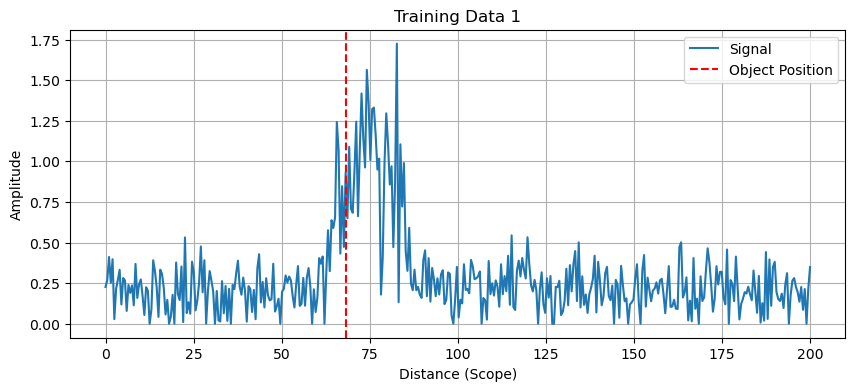

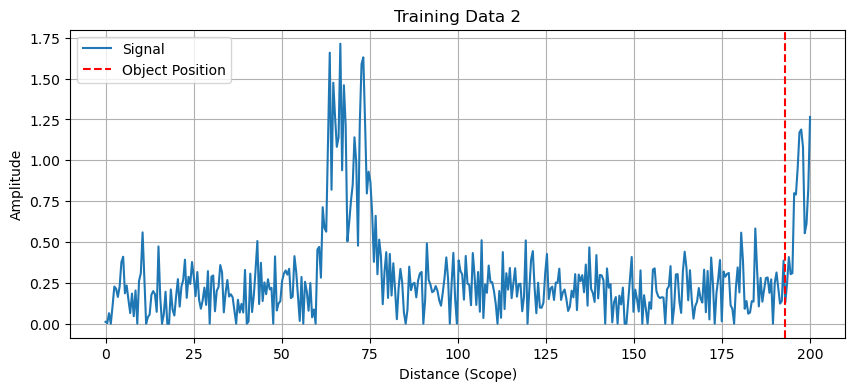

Archivo train_data.csv guardado correctamente
Archivo test_data.csv guardado correctamente


In [136]:



import random

def plot_signal(signal: np.ndarray, object_position: int, scope: int, title: str = "Generated Signal") -> None:
    plt.figure(figsize=(10, 4))
    
    # Genera un eje x escalado desde 0 a scope con la misma cantidad de puntos que signal
    x_values = np.linspace(0, scope, len(signal))
    
    plt.plot(x_values, signal, label="Signal")
    plt.axvline(x=x_values[object_position], color='red', linestyle='--', label="Object Position")
    
    plt.title(title)
    plt.xlabel("Distance (Scope)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()


def visualize_random_signals(x_data, y_data, num_value, scope, title_prefix="Sample"):
    """
    Grafica dos señales aleatorias del conjunto de datos.
    """
    indices = random.sample(range(len(x_data)), 2)
    for i, idx in enumerate(indices):
        plot_signal(x_data[idx], int(y_data[idx] * (num_value - 1)), scope, title=f"{title_prefix} {i+1}")

visualize_random_signals(x_train, y_train, num_value, scope, title_prefix="Training Data")

train_df = pd.DataFrame(x_train, columns=[f'distance_bin_{i+1}' for i in range(num_value)])
train_df['object_distance'] = y_train  # Agregar la columna de etiquetas
train_df.to_csv(f"train_data_{scope}cm.csv", index=False)

print("Archivo train_data.csv guardado correctamente")

test_df = pd.DataFrame(x_test, columns=[f'distance_bin_{i+1}' for i in range(num_value)])
test_df['object_distance'] = y_test  # Agregar la columna de etiquetas
test_df.to_csv(f"test_data_{scope}cm.csv", index=False)

print("Archivo test_data.csv guardado correctamente")
